# The big matrix algorithm test for moving barrier constraint

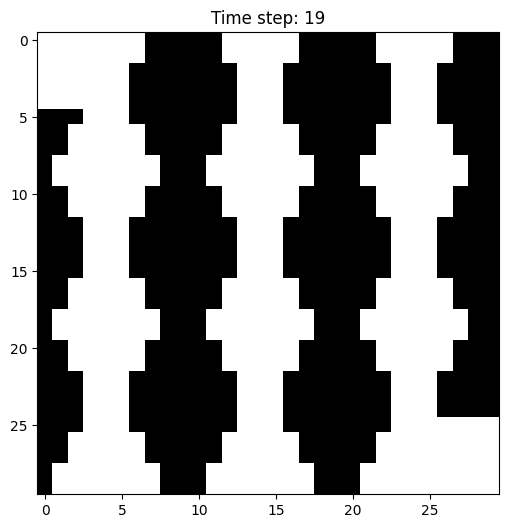

In [5]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('../../..')
from proximal.dynamicUOT import computeGeodesic
from proximal.grids import speed_and_growth
import ipywidgets as widgets
from ipywidgets import interact
from PIL import Image
from matplotlib.animation import FuncAnimation

def generate_dynamic_maze(T, H, W, scale_x, scale_y, amp_x, amp_y, scale_t, offset):
    """
    Generates a dynamic maze with shape (T, H, W) = (16, 60, 60), where:
      - 1 indicates a wall,
      - 0 indicates a passage.
    The top-left 5x5 and bottom-right 5x5 cells are forced to be passages.
    """
    
    maze = np.zeros((T, H, W), dtype=np.int8)

    
    import math
    for t in range(T):
        for x in range(H):
            for y in range(W):
                val = (amp_x * math.sin(math.pi * (x / scale_x + t / scale_t))
                       + amp_y * math.cos(math.pi * (y / scale_y - t / scale_t))) + offset
                if val > 0.0:
                    maze[t, x, y] = 1  # wall
                else:
                    maze[t, x, y] = 0  # passage
    
    # Force the top-left 5x5 region to be a passage
    maze[:, 0:5, 0:5] = 0
    # Force the bottom-right 5x5 region to be a passage
    maze[:, H-5:H, W-5:W] = 0
    
    return maze

def animate_maze(maze):
    """
    Displays an animation of the 3D maze data (time, height, width).
    """
    T = maze.shape[0]

    fig, ax = plt.subplots(figsize=(6, 6))
    # Show the first time step
    im = ax.imshow(maze[0], cmap='binary', vmin=0, vmax=1)
    ax.set_title("Time step: 0")

    # Update function for each frame in the animation
    def update(frame):
        im.set_data(maze[frame])
        ax.set_title(f"Time step: {frame}")
        return [im]

    # Create the animation
    ani = FuncAnimation(fig, update, frames=range(T), interval=500, blit=True)
    ani.save('data/output/animated_maze.gif', fps=2)
    plt.show()

T, N1, N2, scale_x, scale_y, amp_x, amp_y, scale_t, offset = 20, 30, 30, 5.0, 5.0, 1.0, 2.0, 5.0, 0.15
maze = generate_dynamic_maze(T, N1, N2, scale_x, scale_y, amp_x, amp_y, scale_t, offset)
animate_maze(maze)

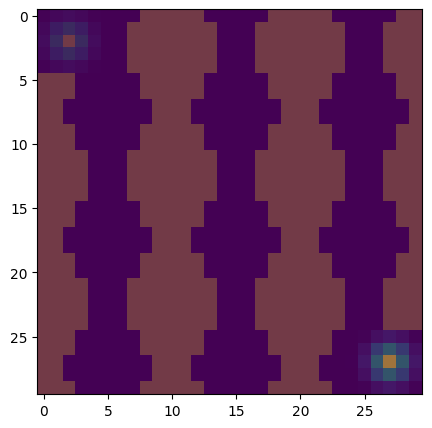

In [6]:
H = maze.astype(np.float32)
F = np.zeros((T,))

dx = [1./N1, 1./N2]

indices = np.arange(0, N1) * 1./N1
xx, yy = np.meshgrid(indices, indices)

rho_0 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[2./N1, 2./N2], cov=1./(N1)**2)
rho_0[H[0] > 0] = 0
rho_1 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[(N2-3)/N2, (N2-3)/N2], cov=1./(N1)**2)
rho_1[H[0] > 0] = 0

plt.figure(figsize=(5, 5))
plt.imshow(maze[0])
plt.imshow(rho_0, alpha=0.5)
plt.imshow(rho_1, alpha=0.5)
plt.show()  

In [17]:
ll = (1.0, 1.0, 1.0)
niter = 10000
delta = 10.0
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p=2.0, q=2.0, delta=delta, niter=niter, big_matrix=True, verbose=True, init='fisher-rao')

Computing a geodesic for optimal transport with source and constraint...


c:\Users\mao17\Workspace\pdot\venv\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Progress: 99%
Done.


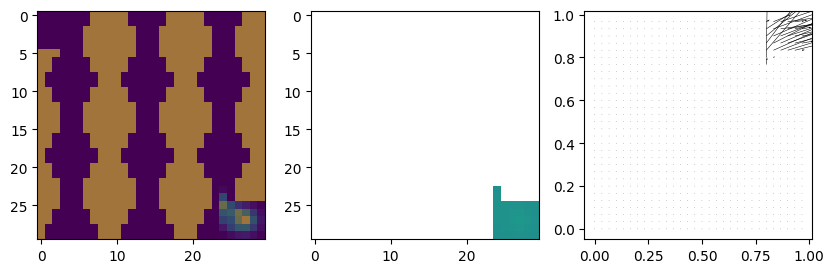

In [18]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, axes = plt.subplots(1, 3, figsize=[10, 5])
ax1, ax2, ax3 = axes

# Make global references to your images/quivers so you can update them
im1 = ax1.imshow(np.zeros((10,10)), animated=True)  # placeholders
im2 = ax2.imshow(np.zeros((10,10)), vmin=-5, vmax=5, animated=True)
quiv = ax3.quiver([], [], [], [], cmap="gray_r")

def init():
    # Any static initialization
    ax3.set_aspect('equal', adjustable='box')
    ax3.invert_yaxis()
    return (im1, im2, quiv)

def update(t):
    # Clear or update each axis, or just update data in the existing artists
    ax1.clear()
    ax2.clear()
    ax3.clear()

    # Possibly replicate logic from plot_maze_2, but do not create new figures.
    # For example:
    ax1.imshow(H[t] > 0)
    ax1.imshow(x.V.D[0][t], alpha=0.5)
    masked = np.ma.masked_where(np.abs(x.V.Z[t]) < 1e-3, x.V.Z[t])
    im2 = ax2.imshow(masked, vmin=-5, vmax=5, animated=True)
    quiv = ax3.quiver(xx, yy, x.V.D[2][t], x.V.D[1][t], cmap="gray_r")
    ax3.invert_yaxis()
    ax3.set_aspect('equal', adjustable='box')

    return (im1, im2, quiv)

ani = FuncAnimation(fig, update, frames=range(T),
                    init_func=init, blit=False)

ani.save(f"data/output/sinusoidal_dynamic_{T}_{N1}_{N2}_{scale_x}_{scale_y}_{amp_x}_{amp_y}_{scale_t}_{offset}_{niter}_{delta}_fisherrao.mp4", fps=6)


<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\i'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\i'
C:\Users\mao17\AppData\Local\Temp\ipykernel_44080\1544966775.py:17: SyntaxWarning: invalid escape sequence '\s'
  plt.title("$\sum_{t}|\int_{\Omega}H(t,x)d\\rho_t(x)-F(t)|$ at each iteration")
C:\Users\mao17\AppData\Local\Temp\ipykernel_44080\1544966775.py:21: SyntaxWarning: invalid escape sequence '\i'
  plt.title("$|\int_{\Omega}H(t,x)d\\rho_t(x)-F(t)|$ at each t for the final solution")


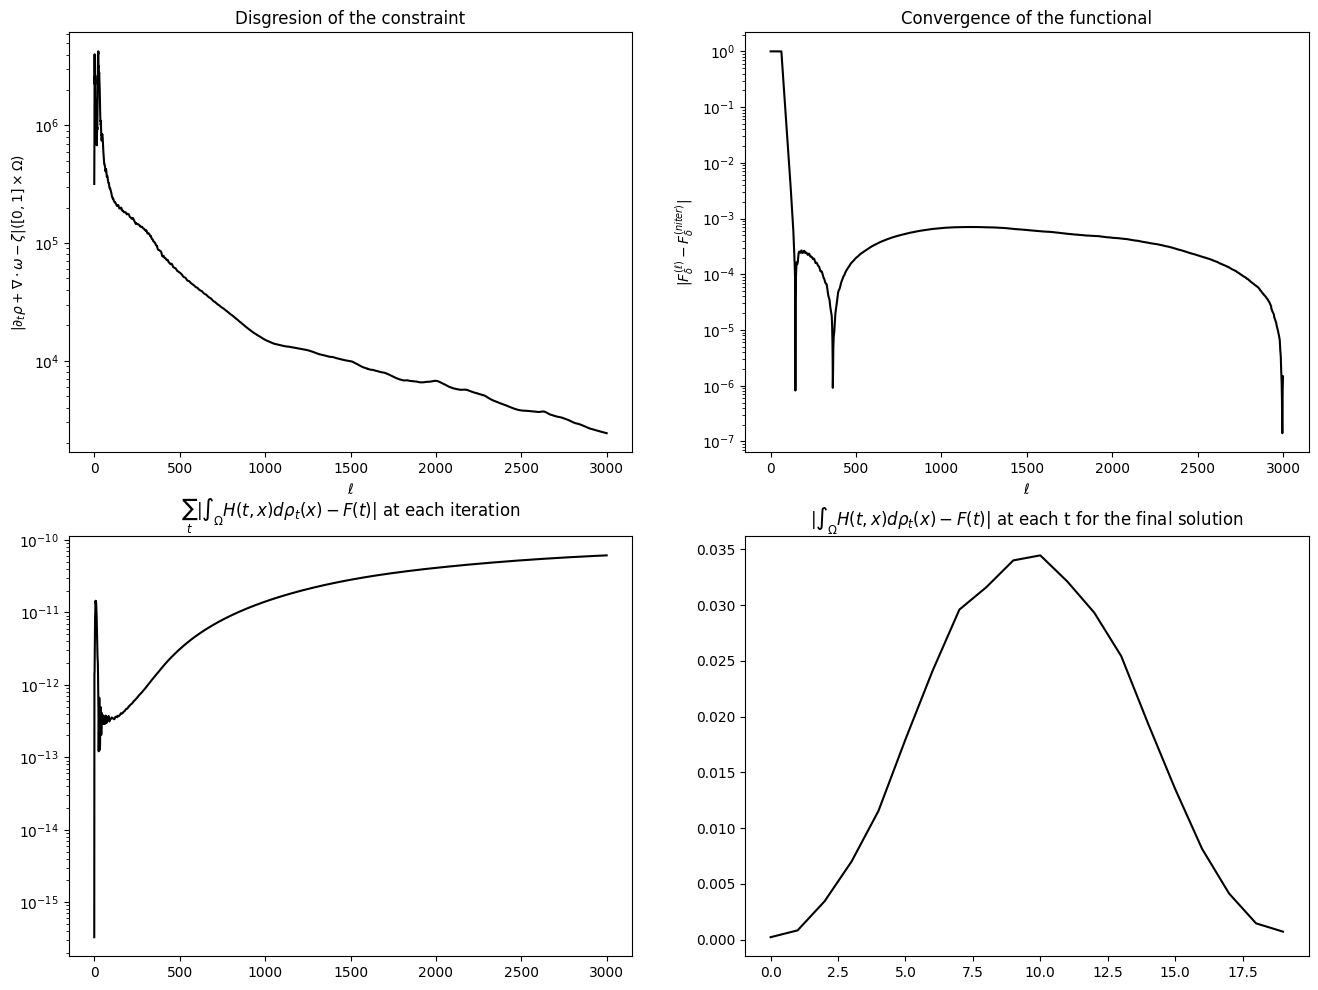

In [14]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.ylabel(r"$|\partial_t \rho + \nabla \cdot \omega - \zeta|([0,1]\times \Omega)$")
plt.xlabel(r"$\ell$")
plt.title("Disgresion of the constraint")
plt.semilogy(lists[1], "k")

plt.subplot(2, 2, 2)
plt.ylabel(r"$|F_{\delta}^{(\ell)}-F_{\delta}^{(niter)}|$")
plt.xlabel(r"$\ell$")
plt.title("Convergence of the functional")
minF = np.min(lists[0][-10:])
plt.semilogy(np.minimum(1, np.abs(lists[0] - np.mean(lists[0][-10:]))), "k")

plt.subplot(2, 2, 3)
plt.title("$\sum_{t}|\int_{\Omega}H(t,x)d\\rho_t(x)-F(t)|$ at each iteration")
plt.semilogy(lists[2], "k")

plt.subplot(2, 2, 4)
plt.title("$|\int_{\Omega}H(t,x)d\\rho_t(x)-F(t)|$ at each t for the final solution")
plt.plot(np.abs(np.sum(x.V.D[0]*H, axis=(1,2))*1./900.-F), "k")

plt.show()

